In [1]:
import numpy as np
from scipy.stats import norm, t
import scipy.special as sc
from scipy.special import kl_div
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import seaborn as sns
sns.set()
import ipdb

In /home/kevin/anaconda3/envs/py3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kevin/anaconda3/envs/py3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kevin/anaconda3/envs/py3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kevin/anaconda3/envs/py3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kevin/anaco

In [2]:
# input data
x = np.arange(-10.0, 10.0, 0.001)
# P distribution attributes
p_loc = 0.0
p_scale = 2.0
p_df = 3.0
# Q distribution attributes
q_loc = 2.0
q_scale = 2.0
q_df = 3.0

### **1) Normal Normal**

***1.1a) Scipy normal PDF function***

KL(P || Q) = sum x in X P(x) * log(P(x) / Q(x))

Source: [MLM](https://machinelearningmastery.com/divergence-between-probability-distributions/), [Cory TDS](https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810), and [Swayson GitHub](https://gist.github.com/swayson/86c296aa354a555536e6765bbe726ff7)

In [3]:
def _kl_divergence(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
    # return sum(p[i] * np.log(p[i]/q[i]) for i in range(len(p)))

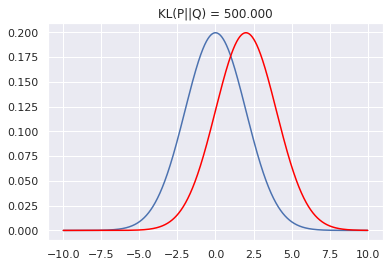

In [4]:
p = norm.pdf(x, loc=p_loc, scale=p_scale)
q = norm.pdf(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***1.1b) Scipy normal PDF function (rewritten here)***

$p(x ; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}exp(-\frac{1}{2}\frac{(x - \mu)^2}{\sigma^2})$

Source: [Scipy norm pdf](https://github.com/scipy/scipy/blob/v1.5.4/scipy/stats/_continuous_distns.py#L242-L243)

In [5]:
def _norm_pdf(x, loc=0., scale=1.):
    return np.exp(-((x-loc)**2 / scale**2) / 2.0) / \
           (scale*np.sqrt(2*np.pi))

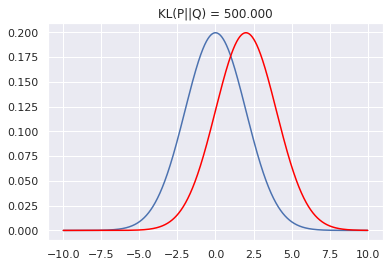

In [6]:
p = _norm_pdf(x, loc=p_loc, scale=p_scale)
q = _norm_pdf(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***1.1c) Scipy normal log PDF function***

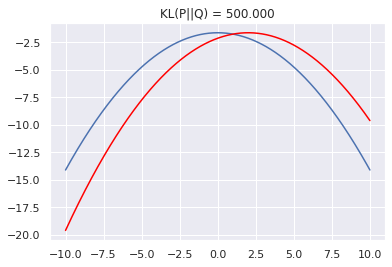

In [7]:
log_p = norm.logpdf(x, loc=p_loc, scale=p_scale)
log_q = norm.logpdf(x, loc=q_loc, scale=q_scale)

# I guess you cannot put log_p and log_q into KL Divergence right???
plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, log_p)
plt.plot(x, log_q, c='red')
plt.show();

***1.1d) Scipy normal log PDF function (rewritten here)***

Source: [Scipy norm log pdf](https://github.com/scipy/scipy/blob/v1.5.4/scipy/stats/_continuous_distns.py#L246-L247)

In [8]:
def _norm_logpdf(x, loc=0., scale=1.):
    return (-((x-loc)**2 / scale**2) / 2.0) - \
           np.log(scale*np.sqrt(2*np.pi))

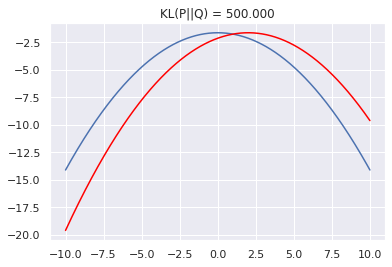

In [9]:
log_p = _norm_logpdf(x, loc=p_loc, scale=p_scale)
log_q = _norm_logpdf(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, log_p)
plt.plot(x, log_q, c='red')
plt.show();

***1.2a) TFP normal PDF function***

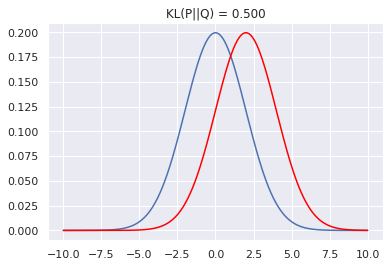

In [10]:
p_dist = tfd.Normal(loc=p_loc, scale=p_scale)
q_dist = tfd.Normal(loc=q_loc, scale=q_scale)
p = p_dist.prob(x)
q = q_dist.prob(x)

plt.title('KL(P||Q) = %1.3f' % p_dist.kl_divergence(q_dist))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***1.2b) TFP normal PDF and KL functions (rewritten here)***

In [11]:
# TFP only has _log_prob written, thus _prob is the exp of that
def _log_prob(x, loc=0., scale=1.):
    scale = tf.convert_to_tensor(scale)
    log_unnormalized = -0.5 * tf.math.squared_difference(
        x / scale, loc / scale)
    log_normalization = tf.constant(
        0.5 * np.log(2. * np.pi), dtype='float32') + tf.math.log(scale)
    return log_unnormalized - log_normalization

def _prob(x, loc=0., scale=1.):
    return tf.exp(_log_prob(x, loc, scale))

In [12]:
def _kl_normal_normal(a, b, name=None):
  """Calculate the batched KL divergence KL(a || b) with a and b Normal.
  Args:
    a: instance of a Normal distribution object.
    b: instance of a Normal distribution object.
    name: Name to use for created operations.
      Default value: `None` (i.e., `'kl_normal_normal'`).
  Returns:
    kl_div: Batchwise KL(a || b)
  """
  with tf.name_scope(name or 'kl_normal_normal'):
    b_scale = tf.convert_to_tensor(b.scale)  # We'll read it thrice.
    diff_log_scale = tf.math.log(a.scale) - tf.math.log(b_scale)
    return (
        0.5 * tf.math.squared_difference(a.loc / b_scale, b.loc / b_scale) +
        0.5 * tf.math.expm1(2. * diff_log_scale) -
        diff_log_scale)

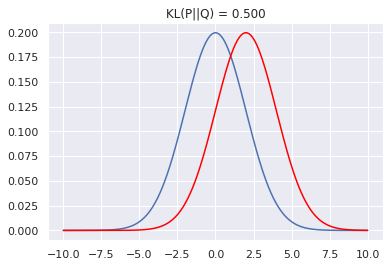

In [13]:
p_dist = tfd.Normal(loc=p_loc, scale=p_scale)
q_dist = tfd.Normal(loc=q_loc, scale=q_scale)
p = _prob(x, loc=p_loc, scale=p_scale)
q = _prob(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_normal_normal(p_dist, q_dist))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***1.2c) TFP normal log PDF function***

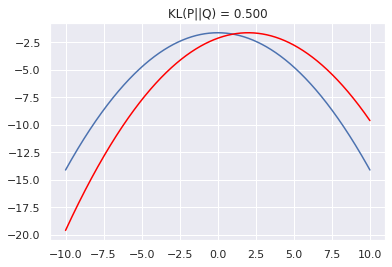

In [14]:
p_dist = tfd.Normal(loc=p_loc, scale=p_scale)
q_dist = tfd.Normal(loc=q_loc, scale=q_scale)
p = p_dist.log_prob(x)
q = q_dist.log_prob(x)

plt.title('KL(P||Q) = %1.3f' % p_dist.kl_divergence(q_dist))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***1.2d) TFP normal log PDF(rewritten here)***

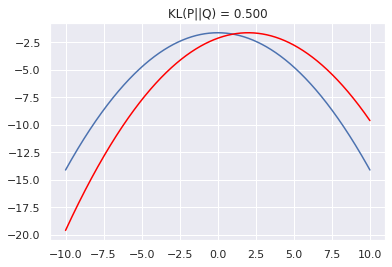

In [15]:
p_dist = tfd.Normal(loc=p_loc, scale=p_scale)
q_dist = tfd.Normal(loc=q_loc, scale=q_scale)
p = _log_prob(x, loc=p_loc, scale=p_scale)
q = _log_prob(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_normal_normal(p_dist, q_dist))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

### **2) Student-t Student-t**

***2.1a) Scipy Student-t PDF function***

Currently used the same KL Divegence function as Normal. Not sure if this is correct.

In [16]:
def _kl_divergence(p, q):
    return sum(p[i] * np.log(p[i]/q[i]) for i in range(len(p)))
    # return np.sum(np.where(p != 0, p * np.log(p / q), 0))

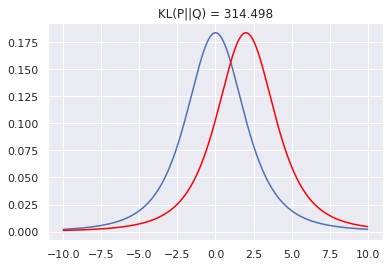

In [17]:
p = t.pdf(x, df=p_df, loc=p_loc, scale=p_scale)
q = t.pdf(x, df=q_df, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***2.1b) Scipy Student-t PDF function (rewritten here)***

$f(t) = \frac{\Gamma[(v + 1)/2]}{\sqrt{v\pi}\Gamma[v/2]}(1 + t^2/v)^{-(v+1)/2}$

Where:

$t = \frac{x - \mu}{\sigma}$

$v = DoF $

$\Gamma = Gamma function $

$d = 1D $

$ \sum = 1$

Source: [Wikipedia](https://en.wikipedia.org/wiki/Multivariate_t-distribution)

Source: [Scipy t pdf](https://github.com/scipy/scipy/blob/v1.5.4/scipy/stats/_continuous_distns.py#L5924-L5931)

In [18]:
#                                gamma((df+1)/2)
# t.pdf(x, df) = ---------------------------------------------------
#                sqrt(pi*df) * gamma(df/2) * (1+x**2/df)**((df+1)/2)
def _t_pdf(x, df=10., loc=0., scale=1.):
    t = np.asarray(((x-loc)/scale)*1.0)
    v = np.asarray(df*1.0)
    Px = np.exp(sc.gammaln((v+1)/2) - sc.gammaln(v/2))
    Px /= np.sqrt(v*np.pi) * (1+(t**2)/v)**((v+1)/2)
    return Px

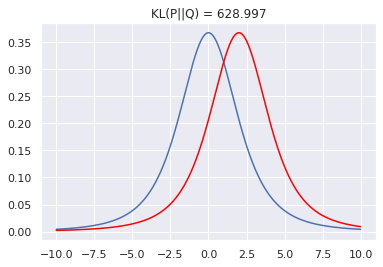

In [19]:
p = _t_pdf(x, df=p_df, loc=p_loc, scale=p_scale)
q = _t_pdf(x, df=q_df, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***2.1c) Scipy Student-t log PDF function***

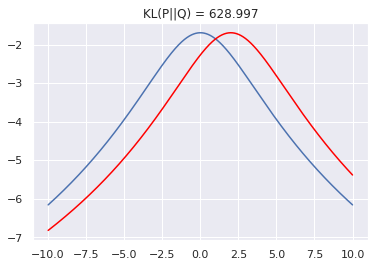

In [20]:
log_p = t.logpdf(x, df=p_df, loc=p_loc, scale=p_scale)
log_q = t.logpdf(x, df=q_df, loc=q_loc, scale=q_scale)

# I guess you cannot put log_p and log_q into KL Divergence right???
plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, log_p)
plt.plot(x, log_q, c='red')
plt.show();

***2.1d) Scipy Student-t log PDF function (rewritten here)***

Source: [Scipy t log pdf](https://github.com/scipy/scipy/blob/v1.5.4/scipy/stats/_continuous_distns.py#L5933-L5937)

In [21]:
def _t_logpdf(x, df=10., loc=0., scale=1.):
    t = ((x-loc)/scale)*1.0
    v = df*1.0
    lPx = sc.gammaln((v+1)/2)-sc.gammaln(v/2)
    lPx -= 0.5*np.log(v*np.pi) + (v+1)/2*np.log(1+(t**2)/v)
    return lPx

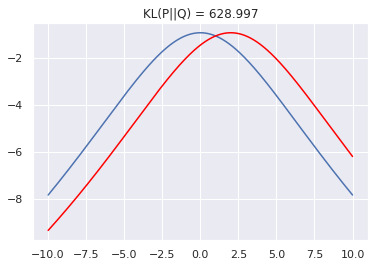

In [22]:
log_p = _t_logpdf(x, loc=p_loc, scale=p_scale)
log_q = _t_logpdf(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_divergence(p, q))
plt.plot(x, log_p)
plt.plot(x, log_q, c='red')
plt.show();

***2.2a) TFP Student-t PDF function***

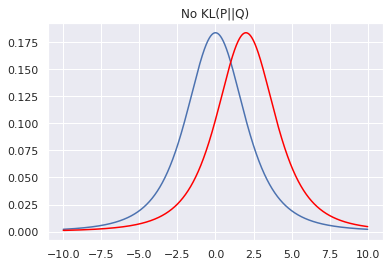

In [23]:
p_dist = tfd.StudentT(df=p_df, loc=p_loc, scale=p_scale)
q_dist = tfd.StudentT(df=q_df, loc=q_loc, scale=q_scale)
p = p_dist.prob(x)
q = q_dist.prob(x)

# plt.title('KL(P||Q) = %1.3f' % p_dist.kl_divergence(q_dist))
plt.title('No KL(P||Q)')
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***2.2b) TFP Student-t PDF and KL functions (rewritten here)***

In [24]:
'''
# TFP only has _log_prob written, thus _prob is the exp of that
def _log_prob(x, loc=0., scale=1.):
    scale = tf.convert_to_tensor(scale)
    log_unnormalized = -0.5 * tf.math.squared_difference(
        x / scale, loc / scale)
    log_normalization = tf.constant(
        0.5 * np.log(2. * np.pi), dtype='float32') + tf.math.log(scale)
    return log_unnormalized - log_normalization

def _prob(x, loc=0., scale=1.):
    return tf.exp(_log_prob(x, loc, scale))
'''

"\n# TFP only has _log_prob written, thus _prob is the exp of that\ndef _log_prob(x, loc=0., scale=1.):\n    scale = tf.convert_to_tensor(scale)\n    log_unnormalized = -0.5 * tf.math.squared_difference(\n        x / scale, loc / scale)\n    log_normalization = tf.constant(\n        0.5 * np.log(2. * np.pi), dtype='float32') + tf.math.log(scale)\n    return log_unnormalized - log_normalization\n\ndef _prob(x, loc=0., scale=1.):\n    return tf.exp(_log_prob(x, loc, scale))\n"

In [25]:
'''
def _kl_normal_normal(a, b, name=None):
  """Calculate the batched KL divergence KL(a || b) with a and b Normal.
  Args:
    a: instance of a Normal distribution object.
    b: instance of a Normal distribution object.
    name: Name to use for created operations.
      Default value: `None` (i.e., `'kl_normal_normal'`).
  Returns:
    kl_div: Batchwise KL(a || b)
  """
  with tf.name_scope(name or 'kl_normal_normal'):
    b_scale = tf.convert_to_tensor(b.scale)  # We'll read it thrice.
    diff_log_scale = tf.math.log(a.scale) - tf.math.log(b_scale)
    return (
        0.5 * tf.math.squared_difference(a.loc / b_scale, b.loc / b_scale) +
        0.5 * tf.math.expm1(2. * diff_log_scale) -
        diff_log_scale)
'''

'\ndef _kl_normal_normal(a, b, name=None):\n  """Calculate the batched KL divergence KL(a || b) with a and b Normal.\n  Args:\n    a: instance of a Normal distribution object.\n    b: instance of a Normal distribution object.\n    name: Name to use for created operations.\n      Default value: `None` (i.e., `\'kl_normal_normal\'`).\n  Returns:\n    kl_div: Batchwise KL(a || b)\n  """\n  with tf.name_scope(name or \'kl_normal_normal\'):\n    b_scale = tf.convert_to_tensor(b.scale)  # We\'ll read it thrice.\n    diff_log_scale = tf.math.log(a.scale) - tf.math.log(b_scale)\n    return (\n        0.5 * tf.math.squared_difference(a.loc / b_scale, b.loc / b_scale) +\n        0.5 * tf.math.expm1(2. * diff_log_scale) -\n        diff_log_scale)\n'

In [26]:
'''
p_dist = tfd.Normal(loc=p_loc, scale=p_scale)
q_dist = tfd.Normal(loc=q_loc, scale=q_scale)
p = _prob(x, loc=p_loc, scale=p_scale)
q = _prob(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_normal_normal(p_dist, q_dist))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();
'''

"\np_dist = tfd.Normal(loc=p_loc, scale=p_scale)\nq_dist = tfd.Normal(loc=q_loc, scale=q_scale)\np = _prob(x, loc=p_loc, scale=p_scale)\nq = _prob(x, loc=q_loc, scale=q_scale)\n\nplt.title('KL(P||Q) = %1.3f' % _kl_normal_normal(p_dist, q_dist))\nplt.plot(x, p)\nplt.plot(x, q, c='red')\nplt.show();\n"

***2.2c) TFP Student-t log PDF function***

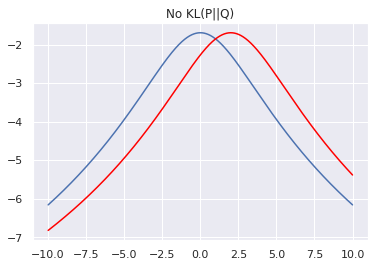

In [27]:
p_dist = tfd.StudentT(df=p_df, loc=p_loc, scale=p_scale)
q_dist = tfd.StudentT(df=q_df, loc=q_loc, scale=q_scale)
p = p_dist.log_prob(x)
q = q_dist.log_prob(x)

# plt.title('KL(P||Q) = %1.3f' % p_dist.kl_divergence(q_dist))
plt.title('No KL(P||Q)')
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();

***2.2d) TFP Student-t log PDF (rewritten here)***

In [28]:
'''
p_dist = tfd.Normal(loc=p_loc, scale=p_scale)
q_dist = tfd.Normal(loc=q_loc, scale=q_scale)
p = _log_prob(x, loc=p_loc, scale=p_scale)
q = _log_prob(x, loc=q_loc, scale=q_scale)

plt.title('KL(P||Q) = %1.3f' % _kl_normal_normal(p_dist, q_dist))
plt.plot(x, p)
plt.plot(x, q, c='red')
plt.show();
'''

"\np_dist = tfd.Normal(loc=p_loc, scale=p_scale)\nq_dist = tfd.Normal(loc=q_loc, scale=q_scale)\np = _log_prob(x, loc=p_loc, scale=p_scale)\nq = _log_prob(x, loc=q_loc, scale=q_scale)\n\nplt.title('KL(P||Q) = %1.3f' % _kl_normal_normal(p_dist, q_dist))\nplt.plot(x, p)\nplt.plot(x, q, c='red')\nplt.show();\n"

### **3) CoupledNormal CoupledNormal**

In [29]:
# TO-DO

### **4) MultivariateCoupledNormal MultivariateCoupledNormal**

In [30]:
# TO-DO